In [158]:
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torchvision
from PIL import Image
from lxml import etree # 网页解析模块，用于解析xml文件
import glob
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

1.8.1+cu102
True


device(type='cuda', index=0)

## 测试一张图片

In [159]:
batch_size = 8
pil_img_ = Image.open("/home/stoner/vscode_workplace/Pytorch_Datasets/datasets/images/Abyssinian_1.jpg")
np_img = np.array(pil_img_)
np_img.shape

(400, 600, 3)

In [160]:
xml = open("/home/stoner/vscode_workplace/Pytorch_Datasets/datasets/annotations/xmls/Abyssinian_1.xml").read()
sel = etree.HTML(xml)
width = int(sel.xpath("//size/width/text()")[0])
height = int(sel.xpath("//size/height/text()")[0])
xmin = int(sel.xpath("//bndbox/xmin/text()")[0])
xmax = int(sel.xpath("//bndbox/xmax/text()")[0])
ymin = int(sel.xpath("//bndbox/ymin/text()")[0])
ymax = int(sel.xpath("//bndbox/ymax/text()")[0])
width, height

(600, 400)

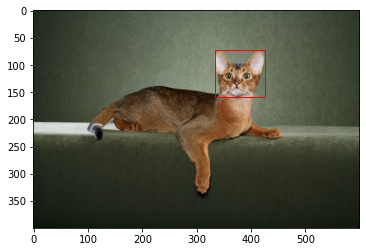

In [161]:
plt.imshow(np_img)
rect = Rectangle(xy=(xmin, ymin), width=(xmax-xmin), height=(ymax-ymin), fill=False, color='red')
ax = plt.gca() # 获取当前坐标系
ax.axes.add_patch(rect) # 在当前坐标系上添加矩形框

In [162]:
pil_img = pil_img_.resize((224, 224))
# 宽度和高度要采用xml中的width和height
# 图像resize之后，其bbox的坐标就需要根据比例进行变换，否则不正确
xmin = (xmin / width) * 224
ymin = (ymin / height) * 224
xmax = (xmax / width) * 224
ymax = (ymax / height) * 224

xmin, ymin, xmax-xmin, ymax-ymin

(124.32000000000001, 40.32, 34.34666666666668, 48.160000000000004)

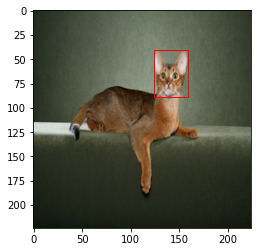

In [163]:
plt.imshow(pil_img)
# 这里的width和height是bbox的宽高，而不是图片的宽高
rect2 = Rectangle(xy=(xmin, ymin), width=(xmax-xmin), height=(ymax-ymin), 
                  fill=False, color='red')
ax3 = plt.gca()
ax3.axes.add_patch(rect2)

## 读取数据

In [164]:
images_path = "/home/stoner/vscode_workplace/Pytorch_Datasets/datasets/images/"
annotations_path = "/home/stoner/vscode_workplace/Pytorch_Datasets/datasets/annotations/xmls/"
images_path_list = sorted(glob.glob(images_path+"*.jpg"))
annotations_path_list = sorted(glob.glob(annotations_path+"*.xml"))
len(images_path_list), len(annotations_path_list)

(7390, 3686)

In [165]:
# 由于annotations_xml数目小于图片数目，因此可以得出并不是所有图片都进行了标注
annotated_images_name = [xml.split("/")[-1].split(".")[0] for xml in annotations_path_list]
images_path_list = [image for image in images_path_list if image.split("/")[-1].split(".")[0] in annotated_images_name]
annotations_path_list[:5]

['/home/stoner/vscode_workplace/Pytorch_Datasets/datasets/annotations/xmls/Abyssinian_1.xml',
 '/home/stoner/vscode_workplace/Pytorch_Datasets/datasets/annotations/xmls/Abyssinian_10.xml',
 '/home/stoner/vscode_workplace/Pytorch_Datasets/datasets/annotations/xmls/Abyssinian_100.xml',
 '/home/stoner/vscode_workplace/Pytorch_Datasets/datasets/annotations/xmls/Abyssinian_101.xml',
 '/home/stoner/vscode_workplace/Pytorch_Datasets/datasets/annotations/xmls/Abyssinian_102.xml']

In [166]:
images_path_list[:5]

['/home/stoner/vscode_workplace/Pytorch_Datasets/datasets/images/Abyssinian_1.jpg',
 '/home/stoner/vscode_workplace/Pytorch_Datasets/datasets/images/Abyssinian_10.jpg',
 '/home/stoner/vscode_workplace/Pytorch_Datasets/datasets/images/Abyssinian_100.jpg',
 '/home/stoner/vscode_workplace/Pytorch_Datasets/datasets/images/Abyssinian_101.jpg',
 '/home/stoner/vscode_workplace/Pytorch_Datasets/datasets/images/Abyssinian_102.jpg']

In [167]:
# 定义函数，转换标签值
def process_xml(xml_path):
    # 为了防止路径字符串转义，可以使用下面的方式
    xml = open(r"{}".format(xml_path)).read()
    sel = etree.HTML(xml)
    width = int(sel.xpath("//size/width/text()")[0])
    height = int(sel.xpath("//size/height/text()")[0])
    xmin = int(sel.xpath("//bndbox/xmin/text()")[0])
    xmax = int(sel.xpath("//bndbox/xmax/text()")[0])
    ymin = int(sel.xpath("//bndbox/ymin/text()")[0])
    ymax = int(sel.xpath("//bndbox/ymax/text()")[0])
    return [xmin/width, ymin/height, xmax/width, ymax/height]
labels = [process_xml(xml_path) for xml_path in annotations_path_list]

index = np.random.permutation(len(images_path_list))
images_path_list = np.array(images_path_list)[index]
labels = np.array(labels)[index].astype(np.float32)

In [168]:
split_ratio = int(len(images_path_list)*0.8)
train_images_path_list = images_path_list[:split_ratio]
train_labels = labels[:split_ratio]
test_images_path_list = images_path_list[split_ratio:]
test_labels = labels[split_ratio:]

In [169]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize(size=((224, 224))),
    transforms.ToTensor(),
])

class OXford_dataset(torch.utils.data.Dataset):
    def __init__(self, images_path, labels):
        self.images_path = images_path
        self.labels = labels
    
    def __getitem__(self, index):
        img_path = self.images_path[index]
        pil_img = Image.open(img_path)
        img_tensor = transform(pil_img)
        xmin, ymin, xmax, ymax = self.labels[index]
        return img_tensor, xmin, ymin, xmax, ymax

    def __len__(self):
        return len(self.images_path)

In [170]:
train_dataset = OXford_dataset(train_images_path_list, train_labels)
test_dataset = OXford_dataset(test_images_path_list, test_labels)
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=32,
                                               shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=32)

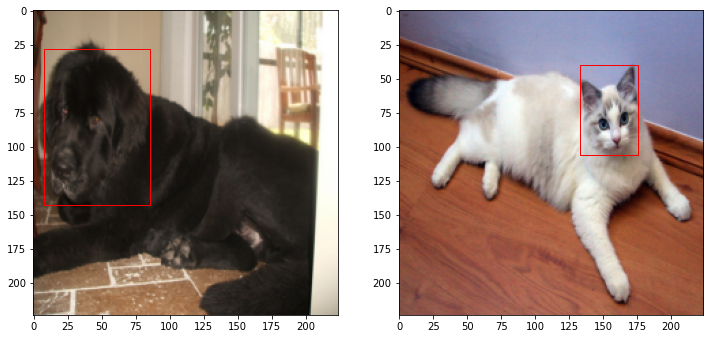

In [171]:
imgs_batch, xmins, ymins, xmaxs, ymaxs = next(iter(train_dataloader))
plt.figure(figsize=(12, 8))
for i, (img, xmin, ymin, xmax, ymax) in enumerate(zip(imgs_batch[:2], xmins[:2], ymins[:2], xmaxs[:2], ymaxs[:2])):
    img = img.permute(1, 2, 0).numpy()
    plt.subplot(1, 2, i+1)
    plt.imshow(img)
    xmin, ymin, xmax, ymax = xmin*224, ymin*224, xmax*224, ymax*224
    rect = Rectangle(xy=(xmin, ymin), width=(xmax-xmin), height=(ymax-ymin), fill=False, color="red")
    ax = plt.gca()
    ax.axes.add_patch(rect)

## 创建定位模型

In [182]:
# 这次使用预训练参数作为初始参数，而不是迁移学习参数，因此不进行冻结
resnet = torchvision.models.resnet101(pretrained=True)
# resnet.children()返回所有层的生成器, *代表对list进行解包，解包完了就可以直接装载到torch.nn.Sequential中
conv_base = torch.nn.Sequential(*list(resnet.children())[:-1])

In [180]:
list(resnet.children())[-1]

Linear(in_features=2048, out_features=1000, bias=True)

In [188]:
class BBox_Location_Net(torch.nn.Module):
    def __init__(self):
        super(BBox_Location_Net, self).__init__()
        self.conv_base = torch.nn.Sequential(*list(resnet.children())[:-1])
        self.bbox_fc_xmin = torch.nn.Linear(in_features=resnet.fc.in_features,
                                            out_features=1)
        self.bbox_fc_ymin = torch.nn.Linear(in_features=resnet.fc.in_features,
                                            out_features=1)
        self.bbox_fc_xmax = torch.nn.Linear(in_features=resnet.fc.in_features,
                                            out_features=1)
        self.bbox_fc_ymax = torch.nn.Linear(in_features=resnet.fc.in_features,
                                            out_features=1)
    def forward(self, input):
        x = self.conv_base(input)
        # xmin, ymin, xmax, ymax = self.bbox_fc(x)
        xmin = self.bbox_fc_xmin(x)
        ymin = self.bbox_fc_ymin(x)
        xmax = self.bbox_fc_xmax(x)
        ymax = self.bbox_fc_ymax(x)
        return xmin, ymin, xmax, ymax 

## 模型训练与预测

In [189]:
model = BBox_Location_Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device=device)

from torchsummary import summary
summary(model, input_size=((3, 224, 224)))

RuntimeError: mat1 dim 1 must match mat2 dim 0

In [ ]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=7, gamma=0.1)

In [ ]:
def fit(model, train_dataloader, test_dataloader, epoch):
    total_num = 0
    running_loss = 0
    model.train() 
    for x, xmin, ymin, xmax, ymax in train_dataloader:
        if torch.cuda.is_available():
            x, xmin, ymin, xmax, ymax = (x.to(device), xmin.to(device), 
                                         ymin.to(device), xmax.to(device), 
                                         ymax.to(device)) # 将数据转移到GPU上
        xmin_pred, ymin_pred, xmax_pred, ymax_pred = model(x)
        loss_xmin = loss_func(xmin_pred, xmin)
        loss_ymin = loss_func(ymin_pred, ymin)
        loss_xmax = loss_func(xmax_pred, xmax)
        loss_ymax = loss_func(ymax_pred, ymax)
        loss = loss_xmin + loss_xmax + loss_ymin + loss_ymax
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            running_loss += loss.item()
    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(train_dataloader.dataset)
    #---------------------------------------------------------------
    test_total_num = 0
    test_running_loss = 0
    model.eval()
    with torch.no_grad():
        for x, xmin, ymin, xmax, ymax in test_dataloader:
            if torch.cuda.is_available():
                x, xmin, ymin, xmax, ymax = (x.to(device), xmin.to(device), 
                                             ymin.to(device), xmax.to(device), 
                                             ymax.to(device)) # 将数据转移到GPU上
            xmin_pred, ymin_pred, xmax_pred, ymax_pred = model(x)
            loss_xmin = loss_func(xmin_pred, xmin)
            loss_ymin = loss_func(ymin_pred, ymin)
            loss_xmax = loss_func(xmax_pred, xmax)
            loss_ymax = loss_func(ymax_pred, ymax)
            loss = loss_xmin + loss_xmax + loss_ymin + loss_ymax
            test_running_loss += loss.item()
    epoch_test_loss = test_running_loss / len(test_dataloader.dataset)
    #---------------------------------------------------------------
    print("epoch = ", epoch, 
          "loss = ", round(epoch_loss, 3),           
          "test_loss = ", round(epoch_test_loss, 3))
    return epoch_loss, epoch_test_loss

In [ ]:
epochs = 10
train_loss = []
test_loss = []
for epoch in range(epochs):
    epoch_loss, epoch_test_loss = fit(model, train_dataloader, test_dataloader, epochs)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)

RuntimeError: mat1 dim 1 must match mat2 dim 0